In [47]:
import numpy as np
import cv2 as cv
import torch
import pandas as pd
import time
from Kalmantool import KalmanFilter
from Analyze import LimitedQueue
from Analyze import CalPeriod

# meta params
QUEUE_LEN = 200

# model = torch.hub.load('ultralytics/yolov5', 'yolov5s') # download from github
model = torch.hub.load('ultralytics/yolov5', 'custom', 'runs/train/exp14/weights/best.pt')

# cap = cv.VideoCapture(0)
# cap = cv.VideoCapture('E:/innovProject/video/walk.mp4')
cap = cv.VideoCapture('E:/innovProject/video/RotationTarget.mp4')

# set Kalman
dt = 1.0/15
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([1, 0, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)
kf_x = KalmanFilter(F=F, H=H, Q=Q, R=R)
kf_y = KalmanFilter(F=F, H=H, Q=Q, R=R)

# locx_base = []
# locy_base = []
# predictions_x = []
# predictions_y = []
locx_base = LimitedQueue(QUEUE_LEN)
locy_base = LimitedQueue(QUEUE_LEN)
predictions_x = LimitedQueue(QUEUE_LEN)
predictions_y = LimitedQueue(QUEUE_LEN)

period_stat = []

current_fps = 0
if not cap.isOpened():
    print('Cannot open camera')
    exit()
while True:
    time_start = time.time()
    ret, image = cap.read()
    if not ret:
        print('Cannot receive frame')
        break
    
    current_fps += 1
    results = model(image)
    locations = results.pandas().xyxy[0]
    try:
        # get locations named 'mark'
        obj = locations.loc[locations['name'] == 'mark']

        # get first target locations
        obj_x = obj.iloc[0]['xmin']
        obj_y = obj.iloc[0]['ymin']
        obj_width = obj.iloc[0]['xmax'] - obj_x
        obj_height = obj.iloc[0]['ymax'] - obj_y
        obj_x = float(obj_x)
        obj_y = float(obj_y)

        # kalman update
        kf_x.update(obj_x)
        kf_y.update(obj_y)

        # after Kalman
        next_x = float(np.dot(H, kf_x.predict())[0])
        next_y = float(np.dot(H, kf_y.predict())[0])
        
        # visualize
        cv.rectangle(image, (int(obj_x), int(obj_y)), (int(obj_x+obj_width), int(obj_y+obj_height)), (0,255,0),2) # yolo
        cv.rectangle(image, (int(next_x), int(next_y)), (int(next_x+obj_width), int(next_y+obj_height)), (255,255,255),2) # kalman 
        
        # save data
        # - current location
        # locx_base.push(obj_x)
        # locy_base.push(obj_y)
        predictions_x.push(next_x)
        predictions_y.push(next_y)
        # - serialize
        x_arr = np.array(locx_base)
        y_arr = np.array(locy_base)

        x_pre_arr = np.array(predictions_x)
        y_pre_arr = np.array(predictions_y)

    except:
        # print('No obj detected')
        predictions_x.push(0)
        predictions_y.push(0)

        x_pre_arr = np.array(predictions_x)
        y_pre_arr = np.array(predictions_y)

    if current_fps > 10:
        current_period = CalPeriod.period(x_pre_arr, process_time)

        # statistics
        period_stat.append(current_period)

        print(current_period)

    cv.imshow('obj', image)   
    time_end = time.time()
    process_time = time_end - time_start

    try: fps = 1 / process_time 
    except: fps = 0
    # print('FPS: ', int(fps), 'serials: ', current_fps)

    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()


Using cache found in C:\Users\LaoZhu/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-11-1 Python-3.8.8 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 2070, 8192MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


0.2968027591705322
0.28798484802246094
0.32501673698425293
0.3500347137451172
0.36007046699523926
0.3999786376953125
0.3909473419189453
0.4500274658203125
0.45613908767700195
0.5209636688232422
0.5669338703155518
0.5594067573547363
0.5757150650024414
0.5511932373046875
0.6008148193359375
0.6445164680480957
0.6645934581756592
0.6942415237426758
0.7538208961486816
0.7199835777282715
0.7440347671508789
0.864013671875
0.8251054286956787
0.7468271255493164
0.9100341796875
0.9345760345458984
1.0114805698394775
0.9120607376098633
0.9362576007843018
0.9274864196777344
0.9856295585632324
1.048201560974121
1.0322225093841553
1.1021547317504883
1.1878108978271484
1.0579233169555664
1.0808207988739014
1.1996726989746094
1.1777372360229494
1.248002052307129
1.2239599227905273
1.3013191223144531
1.3032076358795166
1.2419486045837402
1.3749921321868896
1.4002056121826172
1.4249510765075684
1.5080981254577637
1.534254550933838
1.5600156784057617
1.5250930786132812
1.612060546875
1.6381065845489502
1.5

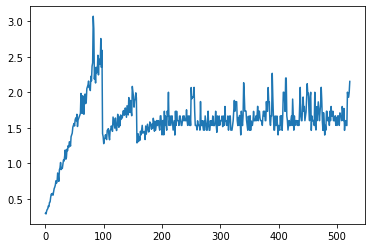

1.5997596931275182

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(period_stat)
plt.show()
sum(period_stat)/len(period_stat)

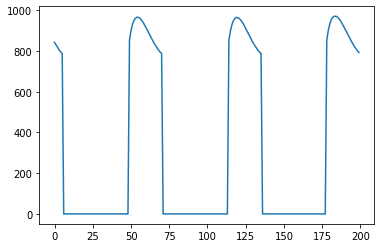

1.466814676920573

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x_pre_arr)
plt.show()

from Analyze import CalPeriod

CalPeriod.period(x_pre_arr, process_time)

In [30]:
import numpy as np
from scipy.fft import fft

# Generate some example data
data = x_pre_arr

# Calculate the time between each frame
frame_time = process_time  # for example, if each frame takes 0.01 seconds to process

# Perform the FFT on the data
fft_data = fft(data)

# Find the power spectrum of the FFT data
power_spectrum = np.abs(fft_data)**2

# Find the frequency corresponding to the maximum power in the spectrum
max_power_idx = np.argmax(power_spectrum[1:len(power_spectrum)//2]) + 1
frequency = max_power_idx / len(data)

# Calculate the period of the data in seconds
period_frames = 1 / frequency
period_time = period_frames * frame_time

print("The period of the data is approximately", period_time, "seconds.")



The period of the data is approximately 1.466814676920573 seconds.
